In [1]:
from IPython.display import HTML

HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
<form action="javascript:code_toggle()"><input type="submit" value="Click here to toggle on/off the raw code."></form>''')

# Contents

* [Executive Summary](#Executive-Summary)
* [fc1000 Feature Engineering](fc1000-Feature-Engineering)
* [Base Model](#Base-Model)
* [PCA Based Model](#PCA-Based-Model)
* [High Frequency Classes](#High-Frequency-Classes)
* [High Frequency With PCA](#High-Frequency-with-PCA)
* [Analyze Iterations at High Frequency and PCA](#Analyze-Iterations-at-High-Frequency-and-PCA)
* [Analyze Iterations at High Frequency without PCA](#Analyze-Iterations-at-High-Frequency-without-PCA)
* [Anayze Learning Curve](#Analyze-Learning-Curve)

# Executive Summary

Our final Spiral 1 model has achieved an accuracy of 72% accuracy after 5 fold CV. This was achieved after the following:
- Only looking at the 3 classes with the highest frequency (FBFM1, FBFM5, Urban).
- FBM2 has a high frequency but is suspected to have a lot of mislabels due to significantly high level of misclassification.
- Reducing the number of features from 1000 to 400 via PCA (capturing 98% variance).

Below shows the iterations of the Spiral 1 model along with their 5 fold CV validation scores:

| Model | Old   | New |
|------|------|------|
|   Base Model  | 55.76% | 54.23% |
|   PCA Based Model  | 56.92% | 55.27% |

The best results were achieved by NOT using PCA and using the following parameters:
* {'loss': 'hinge', 'n_iter': 8, 'penalty': 'none'}

The follow evidence shows that the final model is suffering from high variance:
- The optimal parameters from GridSearchCV are higher than default number of iterations and no penality for regularization. This indicates the model wishes to grow more complex to understand the underlying results better. 
- The learning curve is converging at 100% but the validation score flattens out. Under a high bias or overfit condition, there would be a significant gap between the 2 score curves.

This high variance in our resulting model indicates that the Spiral 1 model is not complex enough. Increasing the complexity of the model (i.e. use a more complex linear model or even a non-linear model) will help improve the accuracy of our model.

# fc1000 Feature Engineering

#### Importing Libraries

In [2]:
# from skicaffe import SkiCaffe
import sys, os, random
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from sklearn.metrics import confusion_matrix
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.preprocessing import normalize
%matplotlib inline

In [3]:
import sklearn
sklearn.__version__

'0.18.1'

#### Set Caffe root

The Caffe binary paths are based on the binaries provided by John. The pre-trained ResNet-50 can be found here:
https://github.com/KaimingHe/deep-residual-networks

In [4]:
# caffe_root = '/usr/local/caffe/'  # this file should be run from {caffe_root}/examples (otherwise change this line)
# sys.path.insert(0, caffe_root + 'python')
# model_prototxt = '/home/ssnazrul/WIFIRE/ResNet50_Analysis/models/ResNet-50-deploy.prototxt'
# model_trained = '/home/ssnazrul/WIFIRE/ResNet50_Analysis/models/ResNet-50-model.caffemodel'

#### Inception Model

Setting up a Deep Learning model based on ResNet-50 that has been pre-trained on ImageNet data for our Inception Model. Check appropriate layer name here:
http://ethereon.github.io/netscope/#/gist/db945b393d40bfa26006

In [5]:
# DLmodel = SkiCaffe(caffe_root=caffe_root, 
#                    model_prototxt_path=model_prototxt, 
#                    model_trained_path=model_trained, 
#                    layer_name='fc1000')

#### Feature Engineering

Passing WIFIRE data through the Inception Model for Feature Engineering.

In [6]:
# #Source Path
# src_path = '/home/ssnazrul/WIFIRE/Processed_Data/LabelledTiles_Fuel_EqualArea/JPG_Files'

# #Paths
# image_types = ('.jpg')
# image_paths = []
# for root, dirs, files in os.walk(src_path):
#     image_paths.extend([os.path.join(root,f) for f in files if f.endswith(image_types)])
    
# #Labels    
# labels = [os.path.basename(f).split('_')[-1][:-4] for f in image_paths]

# #DataFrame
# df = pd.DataFrame({'Path':image_paths, 'Labels':labels})

In [17]:
df = pd.read_csv('~/WIFIRE/Processed_Data/LabelledTiles_Fuel_EqualArea/Reference_Fuel_EqualArea_18May2017_LabelsFromClustering.csv')
df.head()

,Image,FuelFileIndex,NewLabel
0,WIFIRE/Processed_Data/LabelledTiles_Fuel_Equal...,90,B
1,WIFIRE/Processed_Data/LabelledTiles_Fuel_Equal...,104,B
2,WIFIRE/Processed_Data/LabelledTiles_Fuel_Equal...,202,B
3,WIFIRE/Processed_Data/LabelledTiles_Fuel_Equal...,378,B
4,WIFIRE/Processed_Data/LabelledTiles_Fuel_Equal...,409,B


In [18]:
idx = df.FuelFileIndex
labels = df.NewLabel

#### Classification

The engineered features are classified using a linear classifier. Based on available memory, the Logistic Classifier calculates the weights either by matrix manipulation or Stochastic Gradient Descent.

In [42]:
root = "/home/ssnazrul/WIFIRE/ResNet50_Analysis/WIFIRE_Engineered/"

image_features = pd.read_csv(root+"WIFIRE_fc1000_engineered_features.csv",  delimiter=',', header=None)

In [43]:
image_features = image_features.ix[idx,:].values #convert df to np array

# Base Model

The base model uses SGD's default parameters at 5 fold cross validation.

In [44]:
X = normalize(image_features)
y = labels

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

In [45]:
#Logistic Classifier
sgd = SGDClassifier(n_jobs=-1, random_state=0)
parameters =  {'loss':('hinge','log'),
              'penalty':('l1','l2','none'),
              'n_iter':range(1,10)}
        
               
classifier = GridSearchCV(sgd, parameters, cv=5)
classifier.fit(X_train, y_train)

GridSearchCV(cv=5, error_score='raise',
       estimator=SGDClassifier(alpha=0.0001, average=False, class_weight=None, epsilon=0.1,
       eta0=0.0, fit_intercept=True, l1_ratio=0.15,
       learning_rate='optimal', loss='hinge', n_iter=5, n_jobs=-1,
       penalty='l2', power_t=0.5, random_state=0, shuffle=True, verbose=0,
       warm_start=False),
       fit_params={}, iid=True, n_jobs=1,
       param_grid={'penalty': ('l1', 'l2', 'none'), 'loss': ('hinge', 'log'), 'n_iter': [1, 2, 3, 4, 5, 6, 7, 8, 9]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring=None, verbose=0)

In [46]:
#Attempt to predict validation data
predict_target = classifier.predict(X_test)

In [47]:
conf_arr = confusion_matrix(y_test, predict_target)
log_conf_arr = np.log((conf_arr+1)*10000) #For better color choice
norm_conf = []
for i in log_conf_arr:
    a = 0
    tmp_arr = []
    a = sum(i, 0)
    for j in i:
        tmp_arr.append(float(j)/float(a))
    norm_conf.append(tmp_arr)

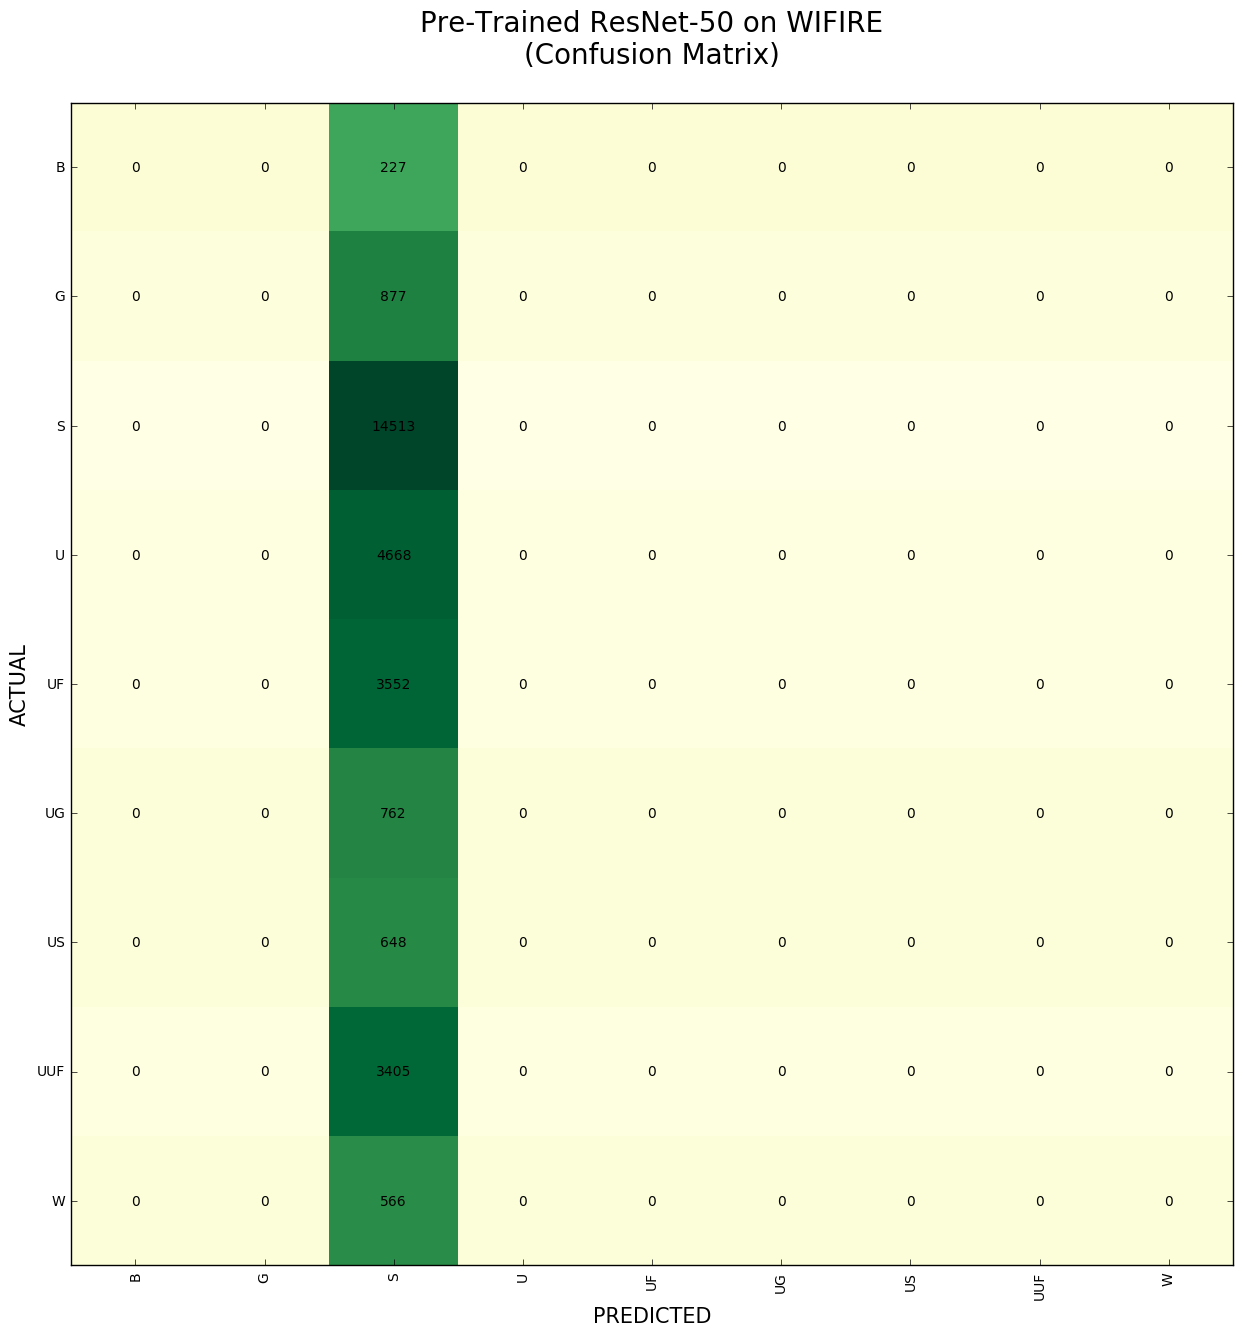

In [48]:
fig = plt.figure(figsize = (15,15))
plt.clf()
ax = fig.add_subplot(111)
ax.set_aspect(1)
res = ax.imshow(np.array(norm_conf), cmap=plt.cm.YlGn, 
                interpolation='nearest')

width, height = conf_arr.shape

for x in range(width):
    for y in range(height):
        ax.annotate(str(conf_arr[x][y]), xy=(y, x), 
                    horizontalalignment='center',
                    verticalalignment='center')

# cb = fig.colorbar(res)
alphabet = np.unique(y_test)
plt.xticks(range(width), alphabet[:width], rotation='vertical')
plt.yticks(range(height), alphabet[:height])
plt.xlabel('PREDICTED', fontsize=15)
plt.ylabel('ACTUAL', fontsize=15)
plt.title('Pre-Trained ResNet-50 on WIFIRE\n(Confusion Matrix)\n', fontsize=20);

Poor classification achieved. The confusion matrix is very... 

CONFUSING!!! (pun intended.. *badam tiss*)

#### Validation Score

In [49]:
((np.sum([y_test == predict_target])*1.0)/(len(y_test)*1.0))*100

49.671435416524062

#### Optimum Parameters

In [ ]:
classifier.best_params_

# PCA Based Model

#### Original Dimensions

In [50]:
from sklearn.decomposition import PCA

M = normalize(image_features)

pca = PCA(n_components=np.shape(M)[1]) 
T = pca.fit_transform(M) 
T.shape

(146087, 1000)

#### Variance Captured by PCA

[ 0.30573455  0.09119605  0.06047109  0.04509057  0.03787385  0.02480992
  0.0204774   0.01833458  0.01690462  0.01552339]


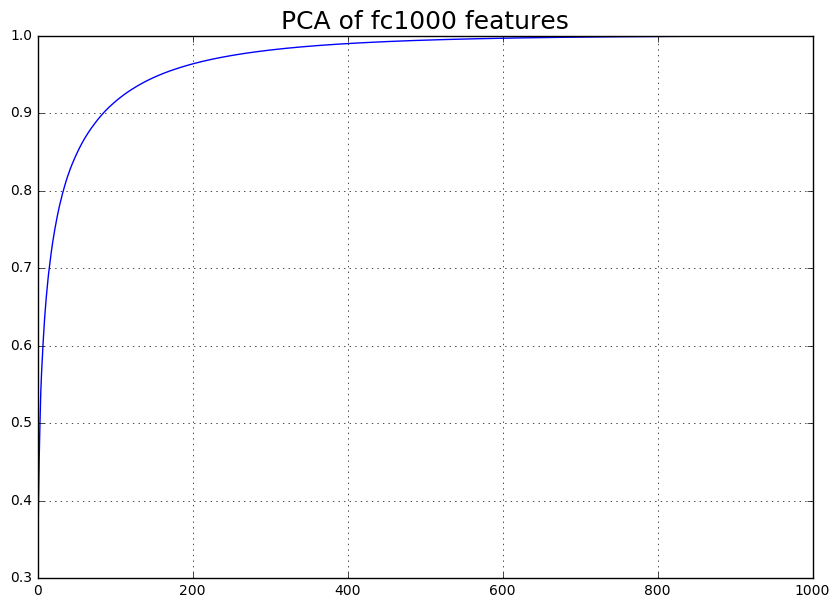

In [51]:
cumulative_explained = np.cumsum(pca.explained_variance_ratio_) 
plt.figure(figsize=(10,7))
plt.plot(cumulative_explained);
#xlim([0,365])
plt.grid()
plt.title('PCA of fc1000 features', fontsize=18)

print(pca.explained_variance_ratio_[:10])

In [52]:
pca = PCA(n_components=400) 
T = pca.fit_transform(M) 

In [53]:
n_samples = len(df)
X = normalize(T)
y = labels

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

In [54]:
#Logistic Classifier
sgd = SGDClassifier(n_jobs=-1, random_state=0)
parameters =  {'loss':('hinge','log'),
              'penalty':('l1','l2','none'),
              'n_iter':range(1,10)}
        
               
classifier = GridSearchCV(sgd, parameters, cv=5)
classifier.fit(X_train, y_train)

GridSearchCV(cv=5, error_score='raise',
       estimator=SGDClassifier(alpha=0.0001, average=False, class_weight=None, epsilon=0.1,
       eta0=0.0, fit_intercept=True, l1_ratio=0.15,
       learning_rate='optimal', loss='hinge', n_iter=5, n_jobs=-1,
       penalty='l2', power_t=0.5, random_state=0, shuffle=True, verbose=0,
       warm_start=False),
       fit_params={}, iid=True, n_jobs=1,
       param_grid={'penalty': ('l1', 'l2', 'none'), 'loss': ('hinge', 'log'), 'n_iter': [1, 2, 3, 4, 5, 6, 7, 8, 9]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring=None, verbose=0)

In [55]:
#Attempt to predict validation data
predict_target = classifier.predict(X_test)

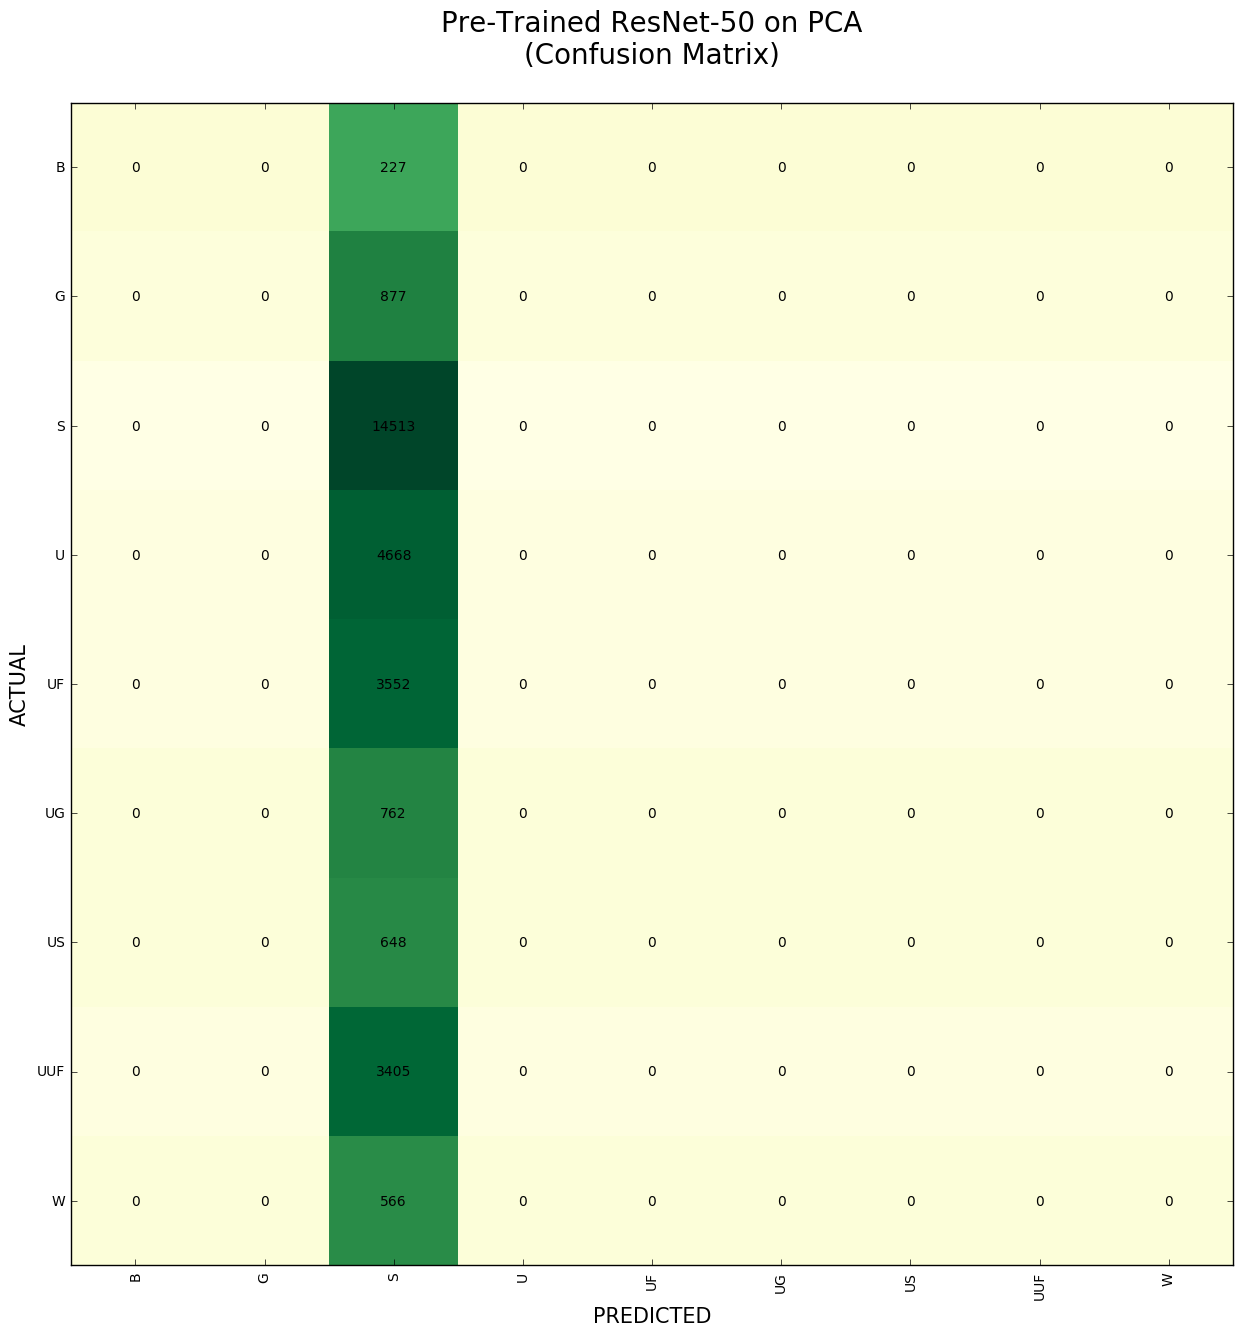

In [56]:
conf_arr = confusion_matrix(y_test, predict_target)
log_conf_arr = np.log((conf_arr+1)*10000) #For better color choice
norm_conf = []
for i in log_conf_arr:
    a = 0
    tmp_arr = []
    a = sum(i, 0)
    for j in i:
        tmp_arr.append(float(j)/float(a))
    norm_conf.append(tmp_arr)
    
fig = plt.figure(figsize = (15,15))
plt.clf()
ax = fig.add_subplot(111)
ax.set_aspect(1)
res = ax.imshow(np.array(norm_conf), cmap=plt.cm.YlGn, 
                interpolation='nearest')

width, height = conf_arr.shape

for x in range(width):
    for y in range(height):
        ax.annotate(str(conf_arr[x][y]), xy=(y, x), 
                    horizontalalignment='center',
                    verticalalignment='center')

# cb = fig.colorbar(res)
alphabet = np.unique(y_test)
plt.xticks(range(width), alphabet[:width], rotation='vertical')
plt.yticks(range(height), alphabet[:height])
plt.xlabel('PREDICTED', fontsize=15)
plt.ylabel('ACTUAL', fontsize=15)
plt.title('Pre-Trained ResNet-50 on PCA\n(Confusion Matrix)\n', fontsize=20);

#### Validation Score

In [57]:
((np.sum([y_test == predict_target])*1.0)/(len(y_test)*1.0))*100

49.671435416524062

#### Optimal Parameters

In [58]:
classifier.best_params_

{'loss': 'log', 'n_iter': 1, 'penalty': 'l1'}

# Analyze Learning Curve

In [ ]:
from sklearn.model_selection import learning_curve

n_samples = len(df)
X = normalize(image_features=)
y = np.array(labels)

clf = SGDClassifier(n_jobs=-1, loss='log', n_iter=9, 
                    penalty='none', random_state=0)

train_percent = np.array([0.60,0.70,0.80,0.90,1.])
                         
train_sizes, train_scores, valid_scores = learning_curve(clf, X, y, cv=5, train_sizes=train_percent)    

In [ ]:
train_av = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)

valid_av = np.mean(valid_scores, axis=1)
valid_std = np.std(valid_scores, axis=1)

plt.figure(figsize=(10,7))
plt.plot(train_percent*100, train_av, 'bo-', label="Training")
plt.plot(train_percent*100, valid_av, 'go-', label="Validation")
plt.xlabel('% Training',fontsize=12)
plt.ylabel('Score',fontsize=12)
plt.axhline(y=train_av[-1], color = 'r', linestyle ='--')
plt.title('Learning Curve',fontsize=16)
plt.legend(fontsize=12)
plt.grid()
print('Optimal Score:\t',train_av[-1])